In [188]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pylab as plt #for visualization
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from config import param_dic

In [189]:
#define function to conenct to sql database
def connect(conn_params_dic):
    conn = None
    try:
        print('Connecting to the PostgreSQL...........')
        conn = psycopg2.connect(**conn_params_dic)
        print("Connection successful..................")
        
    except OperationalError as err:
        # passing exception to function
        show_psycopg2_exception(err)        
        # set the connection to 'None' in case of error
        conn = None
    return conn

In [190]:
# Define a function that handles and parses psycopg2 exceptions
def show_psycopg2_exception(err):
    # get details about the exception
    err_type, err_obj, traceback = sys.exc_info()    
    # get the line number when exception occured
    line_n = traceback.tb_lineno    
    # print the connect() error
    print ("\npsycopg2 ERROR:", err, "on line number:", line_n)
    print ("psycopg2 traceback:", traceback, "-- type:", err_type) 
    # psycopg2 extensions.Diagnostics object attribute
    print ("\nextensions.Diagnostics:", err.diag)    
    # print the pgcode and pgerror exceptions
    print ("pgerror:", err.pgerror)
    print ("pgcode:", err.pgcode, "\n")

In [192]:
#connect to database
conn = connect(param_dic)

Connecting to the PostgreSQL...........
Connection successful..................


In [193]:
#create cursor object
cursor = conn.cursor()

In [194]:
#get data
#for this will just grab the first country which is China
cursor.execute('''SELECT mid_year, population from populations where country_id = '1' ''')


In [195]:
#print result of query
china_df = pd.DataFrame(cursor.fetchall(), columns=['Year', 'Population (Thousands)'])
china_df

,Year,Population (Thousands)
0,1990,1172445
1,1991,1189184
2,1992,1204004
3,1993,1217129
4,1994,1228992
5,1995,1239940
6,1996,1249981
7,1997,1259067
8,1998,1267442
9,1999,1275407


In [196]:
#train test split
#lets do 6 years of training 4 of test
training_data = china_df[0:25]

test_data = china_df[25:]
test_data


,Year,Population (Thousands)
25,2015,1397029
26,2016,1403500
27,2017,1409517
28,2018,1415046
29,2019,1420062
30,2020,1424548
31,2021,1428481


In [197]:
#EDF

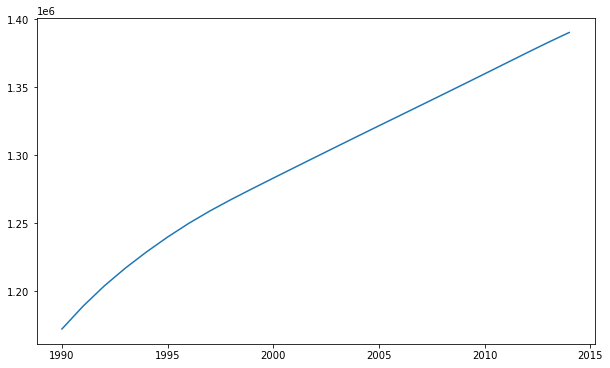

In [198]:
X_training=training_data['Year'].astype('int32')
y_training= training_data['Population (Thousands)'].astype('int32')
plt.plot(X_training,y_training)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

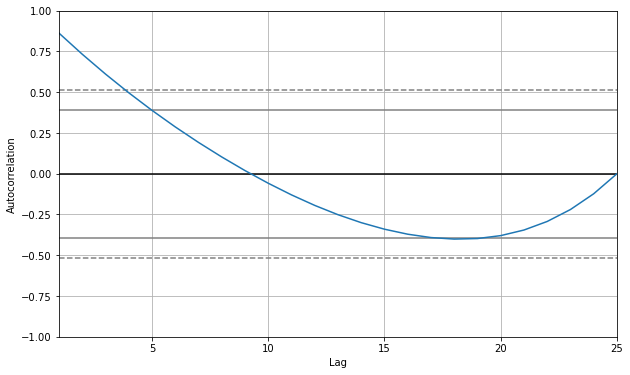

In [199]:
#auto correlation
autocorrelation_plot(y_training)

C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


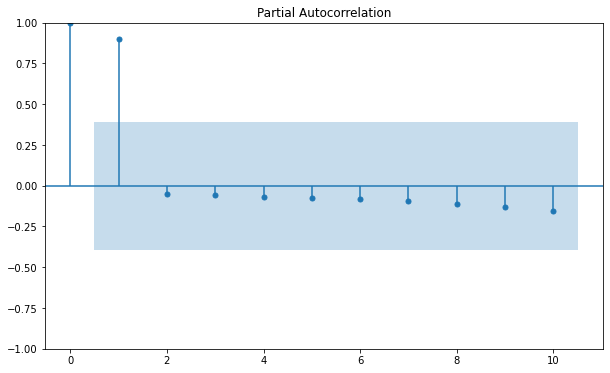

In [200]:
#partial auto correlation
plot_pacf(y_training,lags=10)
plt.show()

In [201]:
#orders for arima model 
# p (from  pacf plot) intercepts y=0 at ~ lag-2, so will start with 2
# Q will start with 0
# 1 for d

                                 SARIMAX Results                                  
Dep. Variable:     Population (Thousands)   No. Observations:                   25
Model:                     ARIMA(2, 1, 0)   Log Likelihood               -1250.250
Date:                    Wed, 13 Jul 2022   AIC                           2506.499
Time:                            12:12:52   BIC                           2510.033
Sample:                                 0   HQIC                          2507.437
                                     - 25                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8320      0.018     45.939      0.000       0.796       0.867
ar.L2          0.0862      0.017      5.169      0.000       0.054       0.119
sigma2      2869.525

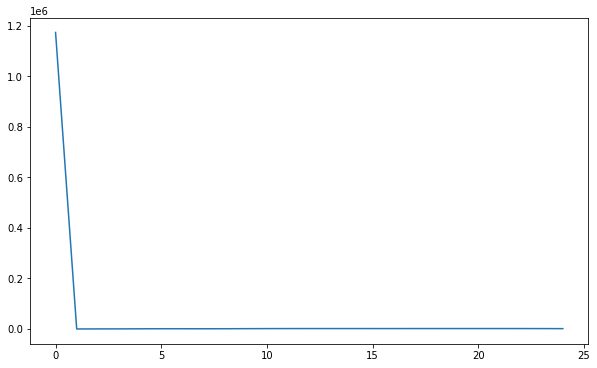

In [202]:
#arima model
model = ARIMA(y_training, order=(2,1,0))
results_AR = model.fit()
print(results_AR.summary())
residuals = results_AR.resid
residuals.plot()
plt.show()


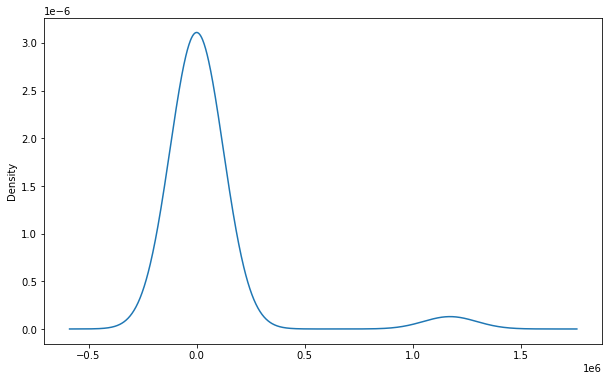

count    2.500000e+01
mean     4.713135e+04
std      2.344409e+05
min     -1.002312e+03
25%     -5.322347e+01
50%      5.695992e+02
75%      6.240751e+02
max      1.172445e+06
dtype: float64


In [203]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [204]:
#making predictions
y_pred = pd.Series(results_AR.forecast(7))
y_pred

25    1.396852e+06
26    1.403092e+06
27    1.408865e+06
28    1.414206e+06
29    1.419147e+06
30    1.423719e+06
31    1.427948e+06
Name: predicted_mean, dtype: float64

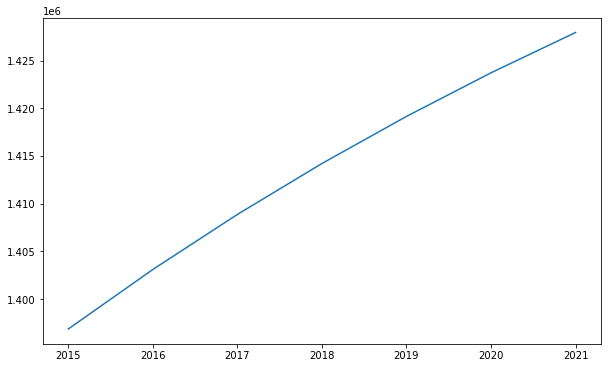

In [205]:
#rename forecast index to correct years
y_pred= y_pred.rename({25:2015, 26:2016, 27:2017, 28:2018, 29:2019, 30:2020, 31:2021})
y_pred.plot()
plt.show()


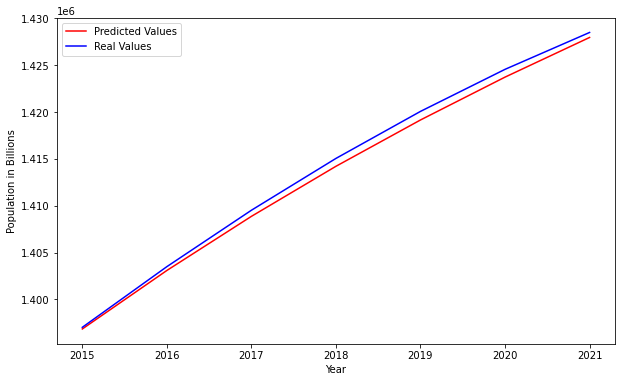

In [210]:
#now plot the model predictions and the test data
y_real = test_data['Population (Thousands)'].astype('int32')
y_real= y_real.rename({25:2015, 26:2016, 27:2017, 28:2018, 29:2019, 30:2020, 31:2021})
y_pred.plot(color='red', label = "Predicted Values")
y_real.plot(color='blue', label = "Real Values")
plt.xlabel("Year")
plt.ylabel('Population in Billions')
plt.legend()
plt.show()

In [207]:
# prediction analysis
#mean absolute percent error
mape = np.mean(np.abs(y_pred-y_real)/np.abs(y_real))

#mean absolute scaled error
n = training_data.shape[0]
d = np.abs(np.diff(y_training)).sum()/(n-1)
errors = np.abs(y_real - y_pred)
mase = errors.mean()/d
print(f"MAPE: {mape}",
     f"\nMASE: {mase}")

MAPE: 0.00043889875655809255 
MASE: 0.0685670301827468


In [208]:
#mape and mase are good for time series as they can deal with the scale of a time series forecast better than other 
#methods of accuracy/error calculation

#mase compares the predictions of the model to a naive model, meaning a model that uses the last observed value as the value
# for all of the predictions
# a mase of 1 means that the model is just as accurate as picking the last observed value over and over as the prediction
# a mase of 0.5 means that the model is twice as accurate as the naive model


#the mape is a measure of error that is scale independent so it is useful for evaluating error of time series forecasting
#the mape is represented as a percentage
# so our mape of 0.04% should be considered a relatively good error.

In [209]:
#room for improvement for sure i think
# the forecasted plot looks very similar to the real values
#which suggests that the prediction is rather accurate.